In [775]:
import numpy as np
import scipy.linalg as la
import itertools as it
import time
import pylab as pl
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from tqdm import tqdm

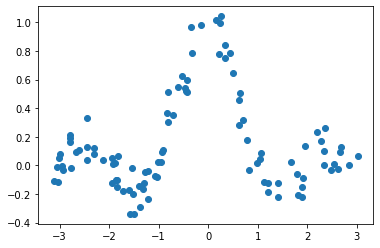

In [776]:
# Test
def noisysincfunction(N, noise):
    ''' noisysincfunction - generate data from the "noisy sinc function"
        % usage
        %     [X, Y] = noisysincfunction(N, noise)
        %
        % input
        %     N: number of data points
        %     noise: standard variation of the noise
        %
        % output
        %     X: (1, N)-matrix uniformly sampled in -2pi, pi
        %     Y: (1, N)-matrix equal to sinc(X) + noise
        %
        % description
        %     Generates N points from the noisy sinc function
        %
        %        X ~ uniformly in [-2pi, pi]
        %        Y = sinc(X) + eps, eps ~ Normal(0, noise.^2)
        %
        % author
        %     Mikio Braun
    '''
    X = np.sort(2 * np.pi * np.random.rand(1, N) ) - np.pi
    Y = np.sinc(X) + noise * np.random.randn(1, N)
    return X.reshape(-1, 1), Y.flatten()
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)
pl.plot(Xtr,Ytr, 'o')

In [777]:
def mean_absolute_error(y_true, y_pred):
    ''' 
    your code here 
    '''
    loss = np.sum(((y_pred-y_true)**2)**0.5) / len(y_pred)
    return loss

In [793]:
#LEONARD'S LATEST VERSION - ADDED TQDM
def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    ''' 
    your header here!
    '''
    # TODO progress bar, run time estimation
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000000
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        e = 0
        for i in range(nrepetitions):
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int')) 
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                print(y_pred)
                e = e + loss_function(y[part[j].astype('int')], y_pred)
        e = e / (nfolds * nrepetitions)
        #print('Loss:' + str(model.cvloss))
        if e < method.cvloss:
            #print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.__params = parameter
    #print(method.params)
    method = model.fit(X,y,method.__params[0],method.__params[1],method.__params[2])
    return method

In [794]:
# LEONARD'S LATEST VERSION - MULTIDIM Y_PRED
class krr():
    ''' your header here!
    '''
    def __init__(self, kernel='linear', kernelparameter=1, regularization=0):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization

    def fit(self, X, y, kernel=False, kernelparameter=False, regularization=False):
        ''' your header here!
        '''
        self.__Xtrain = X
        self.__ytrain = y
        
        if kernel is not False:
            self.kernel = kernel
        if kernelparameter is not False:
            self.kernelparameter = kernelparameter
        if regularization is not False:
            self.regularization = regularization
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        else:
            print("""The following kernel {} is not known. Please use either 'linear' , 'polynomial' or 'gaussian'.""".format(kernel))
        if self.regularization == 0:
            self.__LOOCV()
        
        # calculate optimized alpha
        I_length = len(self.kernelmatrix)
        self.alpha = np.linalg.solve(self.kernelmatrix+self.regularization*np.identity(I_length), self.__ytrain).reshape(-1,len(self.__ytrain))
        
        return self

    def predict(self, X):
        ''' your header here!
        '''
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        # calculate prediction
        y_pred = self.alpha.dot(self.kernelmatrix) # <alpha,kernelmatrix>
        return y_pred.reshape(len(X),len(self.alpha))
    
    def __linearKernel(self,Y):
        self.kernelmatrix = self.__Xtrain.dot(Y.T)
        
    def __polynomialKernel(self,Y):
        self.kernelmatrix = (self.__Xtrain.dot(Y.T)+1)**self.kernelparameter
        
    def __gaussianKernel(self,Y):
        X_len, X_width = self.__Xtrain.shape
        self.kernelmatrix = np.exp(-(np.diagonal(self.__Xtrain.dot(self.__Xtrain.T)).reshape(X_len, 1)-2*self.__Xtrain.dot(Y.T)+np.diagonal(Y.dot(Y.T)))/(2*(self.kernelparameter**2)))
        
    def __LOOCV(self):
        # Leave-One-Out-Cross-Validation
        # starting squared error
        #min_squared_loss = 1000
        # Eigenvalue decomposition
        squared_loss = []
        L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        mean_L = np.mean(L)
        I = np.identity(len(L))
        # for faster computation precalculate U.T.y
        UTy = U.T.dot(self.__ytrain)
        # logarithmic distribution with mu = mean_L and sigma = 1
        # create 50 values of C
        # identify C around Kernel eigenvalue means with logarithmic distribution 
        Cs = np.logspace(-10, 10, 50)*mean_L
        for C in Cs: #np.random.lognormal(mean_L,sigma = 1, size = 30):
            ULCI = U.dot(L*I).dot((1/(L + C))*I) # (1/(L + C))*I: inverse of diagonal matrix
            squared_loss.append(np.sum(((self.__ytrain - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(self.__ytrain))
            print(np.sum(((self.__ytrain - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(self.__ytrain).shape)
        self.regularization = Cs[np.argmin(squared_loss)]
                 
        
        return self

In [830]:
#working CV
def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    ''' 
    your header here!
    '''
    # TODO progress bar, run time estimation
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        e = 0
        for i in range(nrepetitions):
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int')) 
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                e = e + loss_function(y[part[j].astype('int')], y_pred)
        e = e / (nfolds * nrepetitions)
        #print('Loss:' + str(model.cvloss))
        if e < method.cvloss:
            #print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.__params = parameter
    #print(method.params)
    method = model.fit(X,y,method.__params[0],method.__params[1],method.__params[2])
    return method

In [831]:
#working krr - y_pred single dim

class krr():
    ''' your header here!
    '''
    def __init__(self, kernel='linear', kernelparameter=1, regularization=0):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization

    def fit(self, X, y, kernel=False, kernelparameter=False, regularization=False):
        ''' your header here!
        '''
        self.__Xtrain = X
        self.__ytrain = y
        
        if kernel is not False:
            self.kernel = kernel
        if kernelparameter is not False:
            self.kernelparameter = kernelparameter
        if regularization is not False:
            self.regularization = regularization
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        else:
            print("""The following kernel {} is not known. Please use either 'linear' , 'polynomial' or 'gaussian'.""".format(kernel))
        if self.regularization == 0:
            self.__LOOCV()
        
        # calculate optimized alpha
        I_length = len(self.kernelmatrix)
        self.alpha = np.linalg.solve(self.kernelmatrix+self.regularization*np.identity(I_length), y)
        
        return self

    def predict(self, X):
        ''' your header here!
        '''
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        # calculate prediction
        y_pred = self.alpha.dot(self.kernelmatrix) # <alpha, kernelmatrix>
        return y_pred
    
    def __linearKernel(self,Y):
        self.kernelmatrix = self.__Xtrain.dot(Y.T)
        
    def __polynomialKernel(self,Y):
        self.kernelmatrix = (self.__Xtrain.dot(Y.T)+1)**self.kernelparameter
        
    def __gaussianKernel(self,Y):
        X_len, X_width = self.__Xtrain.shape
        self.kernelmatrix = np.exp(-(np.diagonal(self.__Xtrain.dot(self.__Xtrain.T)).reshape(X_len, 1)-2*self.__Xtrain.dot(Y.T)+np.diagonal(Y.dot(Y.T)))/(2*self.kernelparameter**2))
        
    def __LOOCV(self):
        # Leave-One-Out-Cross-Validation
        # starting squared error
        min_squared_loss = 1000
        # Eigenvalue decomposition
        L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        mean_L = np.mean(L)
        I = np.identity(len(L))
        # for faster computation precalculate U.T.y
        UTy = U.T.dot(self.__ytrain)
        
        
        for C in np.logspace(-10, 10, 50)*mean_L: #np.random.lognormal(mean_L,sigma = 1, size = 30):
            ULCI = U.dot(L*I).dot((1/(L + C))*I) # (1/(L + C))*I: inverse of diagonal matrix
            squared_loss = np.sum(((self.__ytrain - np.dot(ULCI,UTy)) / (1-np.diagonal(np.dot(ULCI,(U.T[None,:,:])), axis1=1, axis2=2)).reshape((np.size(C),np.size(self.__ytrain))))**2 ,axis=1) / np.size(self.__ytrain)
            #print('Loss for candiate',C,'\n',squared_loss)
            if squared_loss < min_squared_loss:
                min_squared_loss = squared_loss
                self.regularization = C
        
        #print('Best regularization constant\n',self.regularization)
        return self

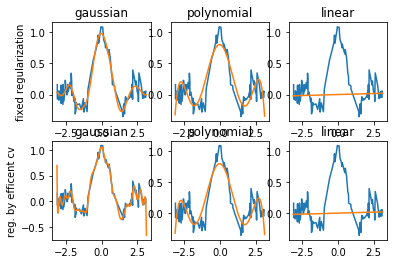

In [834]:
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)

pl.figure()
kernels = ['gaussian','polynomial','linear']
titles = ['gaussian','polynomial','linear']
params = [0.5,6,0]
regularizations = [ 0.01,0.01,0.01]
for i in range(3):
    for j in range(2):
        pl.subplot(2,3,1+i+3*j)
        if j==0:
            model = krr(kernel=kernels[i],
                kernelparameter=params[i],
                regularization=regularizations[i])
            model.fit(Xtr,Ytr)
        if j==1:
            model = krr(kernel=kernels[i],
                kernelparameter=params[i],
                regularization=0)
            model.fit(Xtr,Ytr)
        ypred = model.predict(Xte)
        pl.plot(Xtr,Ytr)
        pl.plot(Xte,ypred)
        if j==0 and i == 0:
            pl.ylabel('fixed regularization')
        if j==1 and i == 0:
            pl.ylabel('reg. by efficent cv')
        pl.title( titles[i] )
pl.show()

(100, 1)
(3,)
(2, 2, 2)


100%|██████████| 600/600 [00:12<00:00, 60.99it/s]


Regularization range: 10**-4 .. 10**4
Gaussian kernel parameter:  0.615848211066026
Regularization paramter:  0.06210169418915616


100%|██████████| 20/20 [00:01<00:00, 15.07it/s]


Regularization via efficient leave on out
Kernel parameter:  1.623776739188721
Regularization paramter:  1e-10


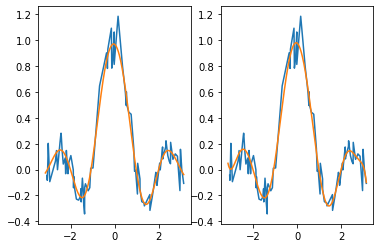

In [835]:
Xtr, Ytr = noisysincfunction(100, 0.1)
print(Xtr.shape)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)


X = np.array([[1,3,5,],[5,3,1],[1,2,3]])
L, U = np.linalg.eigh(X)
print(L.shape)

a = np.array([[[1., 2.], [3., 4.]], [[1, 3], [3, 5]]])
print(a.shape)

pl.figure()
pl.subplot(1,2,1)
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-4,4,20), 'regularization': np.logspace(-5,5,30) }
cvkrr = cv(Xtr, Ytr, krr, params, loss_function=mean_absolute_error, nrepetitions=2)
ypred = cvkrr.predict(Xte)
print('Regularization range: 10**-4 .. 10**4')
print('Gaussian kernel parameter: ', cvkrr.kernelparameter)
print('Regularization paramter: ', cvkrr.regularization)

pl.plot(Xtr,Ytr)
pl.plot(Xte,ypred)

pl.subplot(1,2,2)
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-4,4,20), 'regularization': [0]}
cvkrr = cv(Xtr, Ytr, krr, params, loss_function=mean_absolute_error, nrepetitions=2)
ypred = cvkrr.predict(Xte)
print('Regularization via efficient leave on out')
print('Kernel parameter: ', cvkrr.kernelparameter)
print('Regularization paramter: ', cvkrr.regularization)

pl.plot(Xtr,Ytr)
pl.plot(Xte,ypred)
pl.show()

In [836]:
#ASSIGNMENT 4

#4a
def zero_one_loss(y_true, y_pred):
    ''' 
    Applies a the zero one loss function to predictions.
    
    Input:
    y_true = the true data labels (nx1)
    y_pred = the predicted data labels (nx1)
    
    Output:
    loss = the zero one loss 
    '''
    loss = np.count_nonzero(y_true!=np.sign(y_pred))
    return loss

In [837]:
#4b
# load data 
import os
import pandas as pd
cwd = os.getcwd()

xtrain_names = ['U04_banana-xtrain.dat','U04_diabetis-xtrain.dat','U04_flare-solar-xtrain.dat','U04_image-xtrain.dat','U04_ringnorm-xtrain.dat']
ytrain_names = ['U04_banana-ytrain.dat','U04_diabetis-ytrain.dat','U04_flare-solar-ytrain.dat','U04_image-ytrain.dat','U04_ringnorm-ytrain.dat']
xtest_names = ['U04_banana-xtest.dat','U04_diabetis-xtest.dat','U04_flare-solar-xtest.dat','U04_image-xtest.dat','U04_ringnorm-xtest.dat']
ytest_names = ['U04_banana-ytest.dat','U04_diabetis-ytest.dat','U04_flare-solar-ytest.dat','U04_image-ytest.dat','U04_ringnorm-ytest.dat']

xtrain_data = []
ytrain_data = []
xtest_data = []
ytest_data = []

all_datasets = ['banana','diabetis','flare-solar','image','ringnorm']

folds = [10,9,9,10,10]

for (xtrain,ytrain,xtest,ytest) in zip(xtrain_names,ytrain_names,xtest_names,ytest_names):
    
    path_to_data = cwd + '/data/'+xtrain
    assert os.path.exists(path_to_data), "The path does not exist."
    xtrain_data.append(np.loadtxt(path_to_data))
    
    path_to_data = cwd + '/data/'+ytrain
    assert os.path.exists(path_to_data), "The path does not exist."
    ytrain_data.append(np.loadtxt(path_to_data))
    
    path_to_data = cwd + '/data/'+xtest
    assert os.path.exists(path_to_data), "The path does not exist."
    xtest_data.append(np.loadtxt(path_to_data))
    
    path_to_data = cwd + '/data/'+ytest
    assert os.path.exists(path_to_data), "The path does not exist."
    ytest_data.append(np.loadtxt(path_to_data))

In [838]:
for (xtrain,xtest) in zip(xtrain_data,xtest_data):
    print(xtrain.shape)
    print(xtest.shape)


(2, 400)
(2, 4900)
(8, 468)
(8, 300)
(9, 666)
(9, 400)
(18, 1300)
(18, 1010)
(20, 400)
(20, 7000)


In [850]:
#4b
params = { 'kernel': ['linear','polynomial'], 'kernelparameter': [1,2,3], 'regularization': [0] }

In [851]:
results = {'banana':{'cvloss': [0], 'kernel': [0], 'kernelparameter': [0], 'regularization': [0], 'y_pred': [0]}, 
           'diabetis':{'cvloss': [0], 'kernel': [0], 'kernelparameter': [0], 'regularization': [0], 'y_pred': [0]}, 
           'flare-solar':{'cvloss': [0], 'kernel': [0], 'kernelparameter': [0], 'regularization': [0], 'y_pred': [0]}, 
           'image':{'cvloss': [0], 'kernel': [0], 'kernelparameter': [0], 'regularization': [0], 'y_pred': [0]}, 
           'ringnorm':{'cvloss': [0], 'kernel': [0], 'kernelparameter': [0], 'regularization': [0], 'y_pred': [0]}}



In [852]:
#bug description - "setting an array element with a sequence" if len(xtrain_data) is not equally divisible by nfolds
#solving the bug is very difficult, because it would require converting the unequal sequences into numpy arrays
#and filling the missing values. These values are then indexed on the training data, and will result in an error or a datapoint being used repeatedly
#depending on how you choose to fill the values

#so the obvious solution is to pick n_folds so that len(xtrain)%n_folds=0 ie n_folds is a multiple of xtrain
for (xtrain,ytrain,xtest,ytest,dataset,fold) in zip(xtrain_data,ytrain_data,xtest_data,ytest_data,all_datasets,folds):
    print('Xtrain\n',xtrain.shape)
    print('ytrain\n',ytrain.shape)
    print('Xtest\n',xtest.shape)
    print('ytest\n',ytest.shape)
    
    cvkrr = cv(xtrain.T, ytrain, krr, params, loss_function=zero_one_loss,nfolds=fold, nrepetitions=5)
    y_pred = cvkrr.predict(xtest.T)
    
    results[dataset]['y_pred'] = y_pred
    results[dataset]['kernel'] = cvkrr.kernel
    results[dataset]['kernelparameter'] = cvkrr.kernelparameter
    results[dataset]['regularization'] = cvkrr.regularization
    results[dataset]['cvloss'] = cvkrr.cvloss
    
    

Xtrain
 (2, 400)
ytrain
 (400,)
Xtest
 (2, 4900)
ytest
 (4900,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:00<00:04,  1.08it/s]


 33%|███▎      | 2/6 [00:01<00:03,  1.08it/s]


 50%|█████     | 3/6 [00:03<00:03,  1.23s/it]


 67%|██████▋   | 4/6 [00:05<00:03,  1.51s/it]


 83%|████████▎ | 5/6 [00:08<00:01,  1.68s/it]


100%|██████████| 6/6 [00:10<00:00,  1.90s/it]

Xtrain
 (8, 468)
ytrain
 (468,)
Xtest
 (8, 300)
ytest
 (300,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:03<00:16,  3.23s/it]


 33%|███▎      | 2/6 [00:06<00:13,  3.27s/it]


 50%|█████     | 3/6 [00:10<00:10,  3.35s/it]


 67%|██████▋   | 4/6 [00:13<00:06,  3.41s/it]


 83%|████████▎ | 5/6 [00:16<00:03,  3.37s/it]


100%|██████████| 6/6 [00:21<00:00,  3.60s/it]

Xtrain
 (9, 666)
ytrain
 (666,)
Xtest
 (9, 400)
ytest
 (400,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:08<00:44,  8.95s/it]


 33%|███▎      | 2/6 [00:17<00:35,  8.85s/it]


 50%|█████     | 3/6 [00:26<00:26,  8.88s/it]


 67%|██████▋   | 4/6 [00:34<00:17,  8.74s/it]


 83%|████████▎ | 5/6 [00:42<00:08,  8.52s/it]


100%|██████████| 6/6 [00:54<00:00,  9.34s/it]

Xtrain
 (18, 1300)
ytrain
 (1300,)
Xtest
 (18, 1010)
ytest
 (1010,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [01:10<05:52, 70.53s/it]


 33%|███▎      | 2/6 [02:20<04:41, 70.44s/it]


 50%|█████     | 3/6 [03:26<03:26, 68.97s/it]


 67%|██████▋   | 4/6 [04:37<02:19, 69.59s/it]


 83%|████████▎ | 5/6 [05:44<01:08, 68.75s/it]


100%|██████████| 6/6 [06:59<00:00, 70.86s/it]

Xtrain
 (20, 400)
ytrain
 (400,)
Xtest
 (20, 7000)
ytest
 (7000,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:01<00:09,  1.83s/it]


 33%|███▎      | 2/6 [00:03<00:07,  1.88s/it]


 50%|█████     | 3/6 [00:05<00:05,  1.89s/it]


 67%|██████▋   | 4/6 [00:07<00:03,  1.88s/it]


 83%|████████▎ | 5/6 [00:09<00:01,  1.92s/it]


100%|██████████| 6/6 [00:12<00:00,  2.19s/it]

In [853]:
results

{'banana': {'cvloss': 1362,
  'kernel': 'polynomial',
  'kernelparameter': 3,
  'regularization': 0.7537759923960085,
  'y_pred': array([ 0.3687483 ,  0.78741474, -0.21177065, ...,  0.4852454 ,
         -0.35937164, -0.04900265])},
 'diabetis': {'cvloss': 60,
  'kernel': 'polynomial',
  'kernelparameter': 1,
  'regularization': 2.199032689957164,
  'y_pred': array([-0.02032739, -0.32675715,  0.44647872, -0.38764057, -0.1765885 ,
         -1.22786195,  0.47098386, -0.43372999,  0.08723797, -1.00540826,
         -0.01248009, -0.60417701, -0.42687866, -0.52691554, -1.04526728,
          0.39993517, -0.88081194,  0.66219906, -1.19371236, -0.3660509 ,
         -0.4555347 , -0.44246178, -0.18954708, -0.76695267, -0.52621739,
         -0.72425771, -0.66623091,  0.60495302, -1.03406274, -0.34288374,
         -0.83278251, -0.0261462 ,  0.35540963,  0.30200909, -0.72925183,
          0.16376642, -0.31825644, -0.26688981,  0.78607207, -0.6686633 ,
         -0.39497052, -0.12619718, -0.53054999, -

In [854]:
params = { 'kernel': ['linear','gaussian'], 'kernelparameter': [0.1,0.5,0.9], 'regularization': [0] }

In [855]:
#bug description - "setting an array element with a sequence" if len(xtrain_data) is not equally divisible by nfolds
#solving the bug is very difficult, because it would require converting the unequal sequences into numpy arrays
#and filling the missing values. These values are then indexed on the training data, and will result in an error or a datapoint being used repeatedly
#depending on how you choose to fill the values

#so the obvious solution is to pick n_folds so that len(xtrain)%n_folds=0 ie n_folds is a multiple of xtrain
for (xtrain,ytrain,xtest,ytest,dataset,fold) in zip(xtrain_data,ytrain_data,xtest_data,ytest_data,all_datasets,folds):
    print('Xtrain\n',xtrain.shape)
    print('ytrain\n',ytrain.shape)
    print('Xtest\n',xtest.shape)
    print('ytest\n',ytest.shape)
    
    cvkrr = cv(xtrain.T, ytrain, krr, params, loss_function=zero_one_loss,nfolds=fold, nrepetitions=5)
    y_pred = cvkrr.predict(xtest.T)
    
    if results[dataset]['cvloss'] > zero_one_loss(ytest,y_pred):
        results[dataset]['y_pred'] = y_pred
        results[dataset]['kernel'] = cvkrr.kernel
        results[dataset]['kernelparameter'] = cvkrr.kernelparameter
        results[dataset]['regularization'] = cvkrr.regularization
        results[dataset]['cvloss'] = cvkrr.cvloss
    
    

Xtrain
 (2, 400)
ytrain
 (400,)
Xtest
 (2, 4900)
ytest
 (4900,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:01<00:09,  2.00s/it]


 33%|███▎      | 2/6 [00:03<00:07,  1.97s/it]


 50%|█████     | 3/6 [00:05<00:05,  1.92s/it]


 67%|██████▋   | 4/6 [00:07<00:03,  1.97s/it]


 83%|████████▎ | 5/6 [00:09<00:01,  2.00s/it]


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]

Xtrain
 (8, 468)
ytrain
 (468,)
Xtest
 (8, 300)
ytest
 (300,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:03<00:16,  3.20s/it]


 33%|███▎      | 2/6 [00:06<00:12,  3.22s/it]


 50%|█████     | 3/6 [00:09<00:09,  3.21s/it]


 67%|██████▋   | 4/6 [00:14<00:07,  3.80s/it]


 83%|████████▎ | 5/6 [00:18<00:03,  3.75s/it]


100%|██████████| 6/6 [00:22<00:00,  3.82s/it]

Xtrain
 (9, 666)
ytrain
 (666,)
Xtest
 (9, 400)
ytest
 (400,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:08<00:42,  8.45s/it]


 33%|███▎      | 2/6 [00:16<00:33,  8.25s/it]


 50%|█████     | 3/6 [00:23<00:24,  8.07s/it]


 67%|██████▋   | 4/6 [00:33<00:16,  8.49s/it]


 83%|████████▎ | 5/6 [00:42<00:08,  8.78s/it]


100%|██████████| 6/6 [00:52<00:00,  8.96s/it]

Xtrain
 (18, 1300)
ytrain
 (1300,)
Xtest
 (18, 1010)
ytest
 (1010,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [01:13<06:08, 73.71s/it]


 33%|███▎      | 2/6 [02:25<04:52, 73.14s/it]


 50%|█████     | 3/6 [03:34<03:36, 72.01s/it]


 67%|██████▋   | 4/6 [05:13<02:39, 79.89s/it]


 83%|████████▎ | 5/6 [06:26<01:18, 78.01s/it]


100%|██████████| 6/6 [07:48<00:00, 79.18s/it]

Xtrain
 (20, 400)
ytrain
 (400,)
Xtest
 (20, 7000)
ytest
 (7000,)





  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:01<00:09,  1.87s/it]


 33%|███▎      | 2/6 [00:04<00:07,  1.95s/it]


 50%|█████     | 3/6 [00:06<00:06,  2.00s/it]


 67%|██████▋   | 4/6 [00:10<00:05,  2.63s/it]


 83%|████████▎ | 5/6 [00:12<00:02,  2.54s/it]


100%|██████████| 6/6 [00:14<00:00,  2.50s/it]

In [856]:
results

{'banana': {'cvloss': 710,
  'kernel': 'gaussian',
  'kernelparameter': 0.1,
  'regularization': 1.0000000000000003e-10,
  'y_pred': array([ 0.83023918, -0.69408113, -0.63935189, ..., -0.07741218,
          0.58350362, -1.00353389])},
 'diabetis': {'cvloss': 60,
  'kernel': 'polynomial',
  'kernelparameter': 1,
  'regularization': 2.199032689957164,
  'y_pred': array([-0.02032739, -0.32675715,  0.44647872, -0.38764057, -0.1765885 ,
         -1.22786195,  0.47098386, -0.43372999,  0.08723797, -1.00540826,
         -0.01248009, -0.60417701, -0.42687866, -0.52691554, -1.04526728,
          0.39993517, -0.88081194,  0.66219906, -1.19371236, -0.3660509 ,
         -0.4555347 , -0.44246178, -0.18954708, -0.76695267, -0.52621739,
         -0.72425771, -0.66623091,  0.60495302, -1.03406274, -0.34288374,
         -0.83278251, -0.0261462 ,  0.35540963,  0.30200909, -0.72925183,
          0.16376642, -0.31825644, -0.26688981,  0.78607207, -0.6686633 ,
         -0.39497052, -0.12619718, -0.53054999

In [857]:
import pickle
# open a file, where you want to store the data
file = open('results.p', 'wb')

# dump information to that file
pickle.dump(results, file)

# close the file
file.close()

In [901]:
#4c

def roc_fun(y_true, y_pred, biases=100, threshold=0):
    y_pred = y_pred[:, np.newaxis]
    neg = np.sum(np.array(y_true.flatten() == -1))
    pos = len(y_true) - neg
    b = np.linspace(-1,1,biases)
    prediction = (y_pred - b)>threshold
    tpr = prediction[y_true.flatten() == 1, :].sum(axis=0) / pos
    #print('tpr\n',np.shape(tpr))
    fpr = prediction[y_true.flatten() == -1, :].sum(axis=0) / neg
    #print(fpr)
    result = np.squeeze(np.array([fpr,tpr]))
    
    return result


In [902]:

def cv_4(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    ''' 
    This function implements cross validation as a general function.
    
    Inputs:
    X = matrix of data (nxd)
    y = data labels or regression targets (nx1)
    
    '''
    # TODO progress bar, run time estimation
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        e = 0
        for i in range(nrepetitions):
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            #print('part\n',part)
            #print(np.shape(part))
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int')) 
                #print('TRAIN\n',np.shape(train))
                #print(train)
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                e = e + loss_function(y[part[j].astype('int')], y_pred)
                #print(e)
                
        e = e / (nfolds * nrepetitions)
        #bxnx2
            
#             #plot ROC fun
#             plt.figure(figsize=(4,4))
#             plt.plot(e[0], e[1],label='KRR algorithm')
#             plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1),label='Random guess')
#             plt.ylabel('True Positive Rate (TPR)')
#             plt.xlabel('False Positive Rate (FPR)')
#             plt.title('Average ROC curve from a varying bias')
#             plt.legend()

        method.cvloss = e
        #print('Loss in if:' + str(model.cvloss))
        method.__params = parameter      
        
        method = model.fit(X,y,method.__params[0],method.__params[1],method.__params[2])
        return method
        
            
        

In [893]:
results

{'banana': {'cvloss': 710,
  'kernel': 'gaussian',
  'kernelparameter': 0.1,
  'regularization': 1.0000000000000003e-10,
  'y_pred': array([ 0.83023918, -0.69408113, -0.63935189, ..., -0.07741218,
          0.58350362, -1.00353389])},
 'diabetis': {'cvloss': 60,
  'kernel': 'polynomial',
  'kernelparameter': 1,
  'regularization': 2.199032689957164,
  'y_pred': array([-0.02032739, -0.32675715,  0.44647872, -0.38764057, -0.1765885 ,
         -1.22786195,  0.47098386, -0.43372999,  0.08723797, -1.00540826,
         -0.01248009, -0.60417701, -0.42687866, -0.52691554, -1.04526728,
          0.39993517, -0.88081194,  0.66219906, -1.19371236, -0.3660509 ,
         -0.4555347 , -0.44246178, -0.18954708, -0.76695267, -0.52621739,
         -0.72425771, -0.66623091,  0.60495302, -1.03406274, -0.34288374,
         -0.83278251, -0.0261462 ,  0.35540963,  0.30200909, -0.72925183,
          0.16376642, -0.31825644, -0.26688981,  0.78607207, -0.6686633 ,
         -0.39497052, -0.12619718, -0.53054999

Xtrain
 (2, 400)
ytrain
 (400,)













  0%|          | 0/1 [00:00<?, ?it/s]

Xtrain
 (8, 468)
ytrain
 (468,)













  0%|          | 0/1 [00:00<?, ?it/s]

Xtrain
 (9, 666)
ytrain
 (666,)













  0%|          | 0/1 [00:00<?, ?it/s]

Xtrain
 (18, 1300)
ytrain
 (1300,)













  0%|          | 0/1 [00:00<?, ?it/s]

Xtrain
 (20, 400)
ytrain
 (400,)














  0%|          | 0/1 [00:00<?, ?it/s]

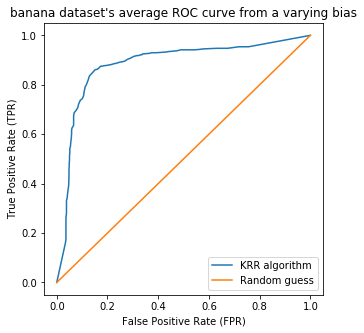

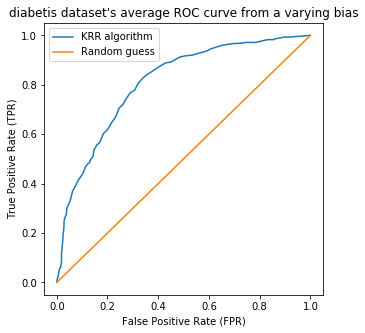

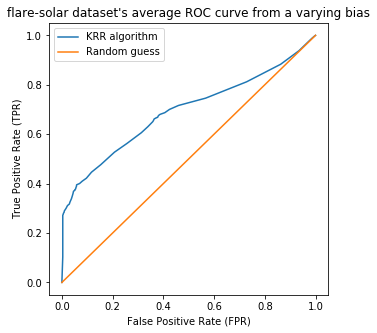

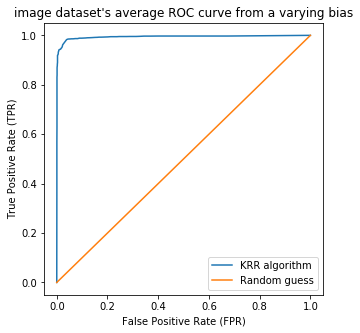

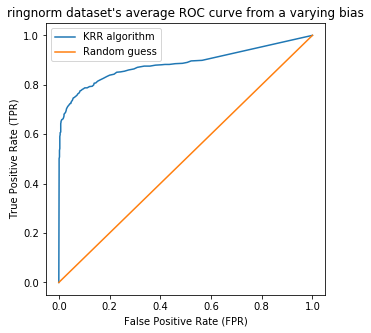

In [908]:
for (xtrain,ytrain,dataset,fold) in zip(xtrain_data,ytrain_data,all_datasets,folds):
    print('Xtrain\n',xtrain.shape)
    print('ytrain\n',ytrain.shape)
    
    params = {'kernel':[str(results[dataset]['kernel'])], 'kernelparameter':[(results[dataset]['kernelparameter'])], 'regularization':[(results[dataset]['regularization'])]}
    #print(params['kernel'])
    cvkrr = cv_4(xtrain.T, ytrain, krr, params, loss_function=roc_fun, nfolds=fold, nrepetitions=4)
    
    loss = cvkrr.cvloss
    #print('fpr\n',loss[0])
    #print('tpr\n',loss[1])
    #print(loss)   
    
    fpr = np.append(loss[0],0)
    fpr = np.insert(fpr,0,1)
    
    tpr = np.append(loss[1],0)
    tpr = np.insert(tpr,0,1)
    
    #plot ROC fun
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr,label='KRR algorithm')
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1),label='Random guess')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.title('%s dataset\'s average ROC curve from a varying bias' %dataset)
    plt.legend()


In [910]:
#4.d

cv_regularisation = []

for (xtrain,ytrain,xtest,ytest,dataset,fold) in zip(xtrain_data,ytrain_data,xtest_data,ytest_data,all_datasets,folds):
    print('Xtrain\n',xtrain.shape)
    print('ytrain\n',ytrain.shape)
    print('Xtest\n',xtest.shape)
    print('ytest\n',ytest.shape)
    
    params = { 'kernel': [results[dataset]['kernel']], 'kernelparameter': [results[dataset]['kernelparameter']], 'regularization': np.linspace(-5,5,11) }
    
    cvkrr = cv(xtrain.T, ytrain, krr, params, loss_function=zero_one_loss,nfolds=fold, nrepetitions=5)
    y_pred = cvkrr.predict(xtest.T)
    
    cv_regularisation.append(cvkrr.cvloss)
    

Xtrain
 (2, 400)
ytrain
 (400,)
Xtest
 (2, 4900)
ytest
 (4900,)















  0%|          | 0/11 [00:00<?, ?it/s]












  9%|▉         | 1/11 [00:00<00:03,  2.59it/s]












 18%|█▊        | 2/11 [00:00<00:03,  2.57it/s]












 27%|██▋       | 3/11 [00:01<00:03,  2.61it/s]












 36%|███▋      | 4/11 [00:01<00:02,  2.44it/s]












 45%|████▌     | 5/11 [00:02<00:02,  2.37it/s]












 55%|█████▍    | 6/11 [00:04<00:05,  1.02s/it]












 64%|██████▎   | 7/11 [00:04<00:03,  1.20it/s]












 73%|███████▎  | 8/11 [00:05<00:02,  1.44it/s]












 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]












 91%|█████████ | 10/11 [00:05<00:00,  2.02it/s]












100%|██████████| 11/11 [00:06<00:00,  2.12it/s]

Xtrain
 (8, 468)
ytrain
 (468,)
Xtest
 (8, 300)
ytest
 (300,)















  0%|          | 0/11 [00:00<?, ?it/s]












  9%|▉         | 1/11 [00:00<00:05,  1.71it/s]












 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]












 27%|██▋       | 3/11 [00:01<00:04,  1.70it/s]












 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]












 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]












 55%|█████▍    | 6/11 [00:06<00:07,  1.50s/it]












 64%|██████▎   | 7/11 [00:07<00:04,  1.23s/it]












 73%|███████▎  | 8/11 [00:07<00:03,  1.04s/it]












 82%|████████▏ | 9/11 [00:08<00:01,  1.11it/s]












 91%|█████████ | 10/11 [00:08<00:00,  1.28it/s]












100%|██████████| 11/11 [00:09<00:00,  1.42it/s]

Xtrain
 (9, 666)
ytrain
 (666,)
Xtest
 (9, 400)
ytest
 (400,)















  0%|          | 0/11 [00:00<?, ?it/s]












  9%|▉         | 1/11 [00:00<00:08,  1.16it/s]












 18%|█▊        | 2/11 [00:01<00:07,  1.15it/s]












 27%|██▋       | 3/11 [00:02<00:06,  1.15it/s]












 36%|███▋      | 4/11 [00:03<00:06,  1.15it/s]












 45%|████▌     | 5/11 [00:04<00:05,  1.13it/s]












 55%|█████▍    | 6/11 [00:12<00:15,  3.05s/it]












 64%|██████▎   | 7/11 [00:13<00:09,  2.37s/it]












 73%|███████▎  | 8/11 [00:14<00:05,  1.89s/it]












 82%|████████▏ | 9/11 [00:14<00:03,  1.56s/it]












 91%|█████████ | 10/11 [00:15<00:01,  1.33s/it]












100%|██████████| 11/11 [00:16<00:00,  1.16s/it]

Xtrain
 (18, 1300)
ytrain
 (1300,)
Xtest
 (18, 1010)
ytest
 (1010,)















  0%|          | 0/11 [00:00<?, ?it/s]












  9%|▉         | 1/11 [00:09<01:31,  9.16s/it]












 18%|█▊        | 2/11 [00:18<01:23,  9.31s/it]












 27%|██▋       | 3/11 [00:30<01:20, 10.08s/it]












 36%|███▋      | 4/11 [00:40<01:09,  9.97s/it]












 45%|████▌     | 5/11 [00:49<00:58,  9.78s/it]












 55%|█████▍    | 6/11 [01:59<02:18, 27.77s/it]












 64%|██████▎   | 7/11 [02:08<01:28, 22.21s/it]












 73%|███████▎  | 8/11 [02:18<00:55, 18.58s/it]












 82%|████████▏ | 9/11 [02:28<00:31, 15.99s/it]












 91%|█████████ | 10/11 [02:38<00:14, 14.03s/it]












100%|██████████| 11/11 [02:46<00:00, 12.44s/it]

Xtrain
 (20, 400)
ytrain
 (400,)
Xtest
 (20, 7000)
ytest
 (7000,)















  0%|          | 0/11 [00:00<?, ?it/s]












  9%|▉         | 1/11 [00:00<00:02,  4.16it/s]












 18%|█▊        | 2/11 [00:00<00:02,  4.27it/s]












 27%|██▋       | 3/11 [00:00<00:01,  4.56it/s]












 36%|███▋      | 4/11 [00:00<00:01,  4.74it/s]












 45%|████▌     | 5/11 [00:01<00:01,  4.36it/s]












 55%|█████▍    | 6/11 [00:03<00:03,  1.32it/s]












 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]












 73%|███████▎  | 8/11 [00:03<00:01,  2.14it/s]












 82%|████████▏ | 9/11 [00:03<00:00,  2.63it/s]












 91%|█████████ | 10/11 [00:03<00:00,  3.13it/s]












100%|██████████| 11/11 [00:04<00:00,  3.60it/s]

In [911]:
cv_regularisation

[4.2, 12.955555555555556, 25.91111111111111, 3.54, 6.02]

In [ ]:
results